In [2]:
# import libraries which can read h5 files
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

# change to inline plotting
%matplotlib inline

In [3]:
def read_file(file_name, resample_rate=10, split_rate=40):
    f = h5py.File(f'/Tmp/dingqian/Ocean/{file_name}', 'r')
    data = f['Data'][:]
    data_resample = data[::resample_rate,:].T # resample per 10 stations
    data_splits = np.split(data_resample, split_rate, axis=0) # to 90 seconds splits

    return data_splits

def read_catalog(file_name):
    # read file using open
    with open(f'data/{file_name}', 'r') as f:
        catalog = f.readlines()
    return catalog

In [4]:
def file_to_npz(data_splits, file_name, set_name, starting_time, interval, catalog, save=False):
    npz_list = []
    has_list = []
    
    for i, data in enumerate(tqdm(data_splits)):
        meta = {}
        meta['data'] = data.astype(np.float64) # (9000, 3260)

        ending_time = starting_time + timedelta(seconds=interval*data.shape[0])

        # save meta to npz
        file_prefix = file_name.split('.')[0]

        if save:
            save_path = f'/Tmp/dingqian/Ocean/splits/{set_name}/{file_prefix}-{i}.npz'
            print(save_path)

            np.savez_compressed(save_path, **meta)
        
        # check if there is any time in catalog between starting_time and ending_time
        for cat_time in catalog:
            # print(cat_time, starting_time, ending_time)
            if starting_time <= cat_time <= ending_time:
                # meta['catalog'] is the number of seconds between starting_time and cat_time divided by interval
                meta['catalog'] = (cat_time - starting_time).seconds / interval
                has_list.append(i)

        npz_list.append(meta)
        starting_time = ending_time
    
    return npz_list, has_list

In [5]:
def plot_data(data):
    data -= np.median(data, axis=1, keepdims=True)
    data -= np.mean(data, axis=0)
    data /= np.std(data, axis=0)

    # data = data[:, 200:400]

    plt.figure(figsize=(10, 8))
    plt.imshow(data.T, vmin=-2.0, vmax=2.0, cmap="seismic", aspect='auto')
    plt.gca().invert_yaxis()
    plt.xlabel("Time")
    plt.ylabel("Station")

In [6]:
def extract_starting_time_str(file_name):
    file_prefix = file_name.split('.')[0]
    time_str = file_prefix.split('-')[-3:]
    time_str = '-'.join(time_str)[:-1]
    time_ret = datetime.strptime(time_str, '%Y-%m-%dT%H%M%S')
    return time_ret

In [7]:
catalog = read_catalog('catalog.DAS')
#strptime where seconds in decimal

catalog = [datetime.strptime(line.split()[0], '%Y-%m-%dT%H:%M:%S.%f') for line in catalog]
catalog[0]

datetime.datetime(2021, 11, 1, 22, 1, 16, 68000)

In [8]:
file_name = 'Cascadia-North-2021-11-01T215345Z.h5'
set_name = 'train_npz'
data_splits = read_file(file_name) # segment in 90 seconds, size in (9000, 3260)

In [9]:
starting_time = extract_starting_time_str('Cascadia-North-2021-11-01T215345Z.h5')
interval = 0.01

npz_list = file_to_npz(data_splits, file_name, set_name, starting_time, interval, catalog, save=False)

100%|██████████| 40/40 [00:01<00:00, 36.78it/s]


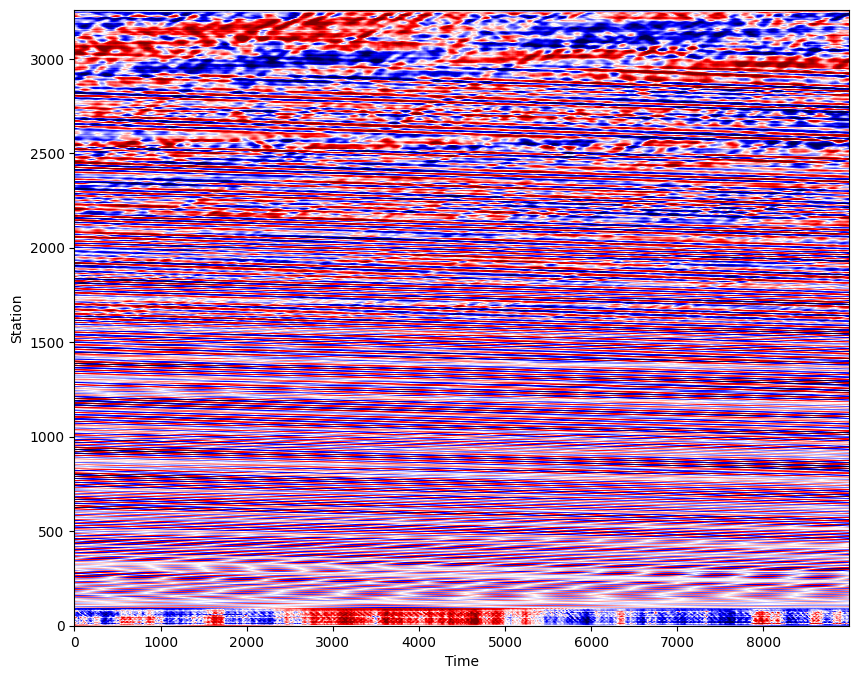

In [10]:
plot_data(npz_list[0]['data'])

In [11]:
print(npz_list[0]['catalog'])

100.0


In [ ]:
############## Old from here

file_name = 'Cascadia-North-2021-11-01T225345Z.h5'
set_name = 'test_npz'

file_to_npz(file_name, set_name)

In [3]:
# read h5 file to numpy array
f = h5py.File(f'/Tmp/dingqian/Ocean/{file_name}', 'r')
data = f['Data'][:]

In [12]:
data_resample = data[::10,:].T
data_resample.shape

(360000, 3260)

In [13]:
data_splits = np.split(data_resample, 40, axis=0) # to 90 seconds split

In [14]:
data_splits[0].shape

(9000, 3260)

In [15]:
def plot_data(data):
    data -= np.median(data, axis=1, keepdims=True)
    data -= np.mean(data, axis=0)
    data /= np.std(data, axis=0)

    data = data[:, 200:400]

    plt.figure(figsize=(10, 8))
    plt.imshow(data.T, vmin=-2.0, vmax=2.0, cmap="seismic", aspect='auto')
    plt.gca().invert_yaxis()
    plt.xlabel("Time")
    plt.ylabel("Station")

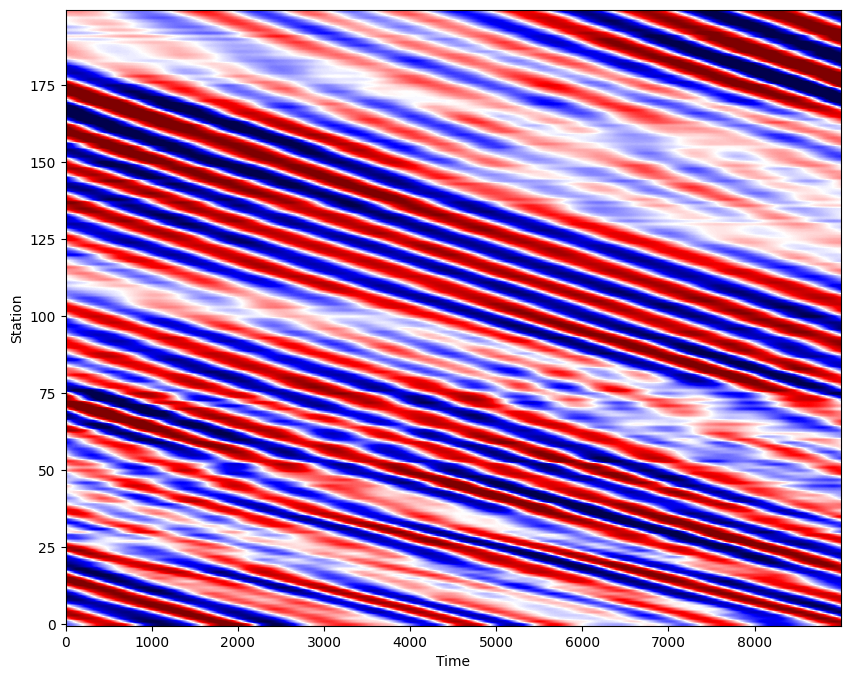

In [16]:
plot_data(data_splits[12])